<a href="https://colab.research.google.com/github/ShreejalBhattarai/Learning_MachineLearning/blob/main/final_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os


# Configuration & Utilities


In [5]:
SEED = 42
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
NUM_EPOCHS = 10
LR = 1e-3
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_PATH = "resnet50_model_state_dict.pth"

In [6]:
# Set random seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform_c1 = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    normalize
])

transform_c3 = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])


In [8]:
class ClasswiseTransformImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform_map):
        super().__init__(root, transform=None)
        self.transform_map = transform_map

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        if label in self.transform_map:
            img = self.transform_map[label](img)
        return img, label


In [9]:
def get_model():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    return model.to(DEVICE)

def save_model(model, path=SAVE_PATH):
    torch.save(model.state_dict(), path)

def load_model(path=SAVE_PATH):
    model = get_model()
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.eval()
    return model

In [10]:
def train(model, train_loader, val_loader, epochs=NUM_EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")


In [11]:
def evaluate(model, loader, class_names):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))
    return all_labels, all_preds, all_probs


In [12]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [13]:
def plot_roc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [14]:
transform_map = {
    0: transform_c1,
    1: transform_c3
}
from google.colab import drive
drive.mount('/content/drive')
dataset = ClasswiseTransformImageFolder('/content/drive/MyDrive/OP_Rolling_Ball_Imgs', transform_map)


Mounted at /content/drive


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


Epoch 1/10, Loss: 0.6339
Epoch 2/10, Loss: 0.2416
Epoch 3/10, Loss: 0.1420
Epoch 4/10, Loss: 0.1172
Epoch 5/10, Loss: 0.0872
Epoch 6/10, Loss: 0.0700
Epoch 7/10, Loss: 0.0670
Epoch 8/10, Loss: 0.0550
Epoch 9/10, Loss: 0.0641
Epoch 10/10, Loss: 0.0675

Evaluating model...
              precision    recall  f1-score   support

          C1       1.00      0.98      0.99        42
          C3       0.97      1.00      0.99        33

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



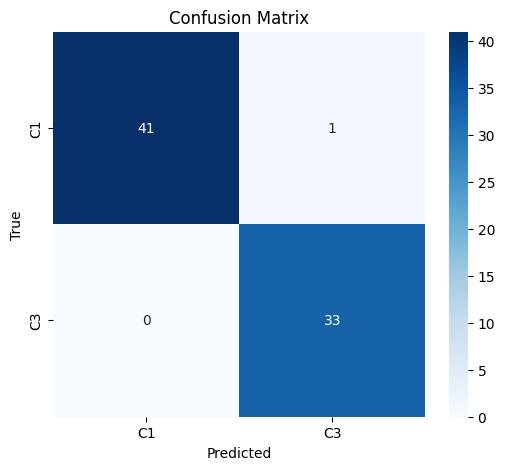

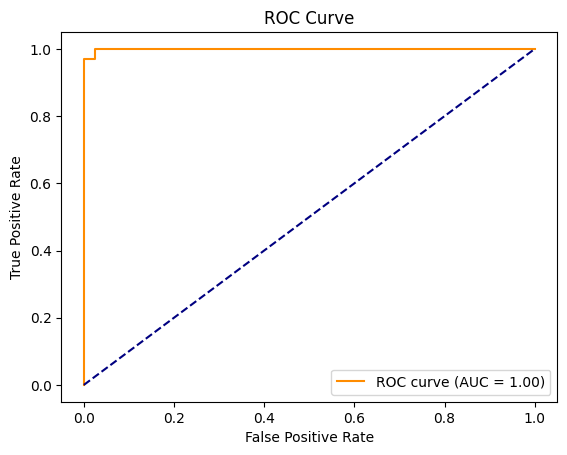

In [13]:
def main():
    dataset = ClasswiseTransformImageFolder('/content/drive/MyDrive/OP_Rolling_Ball_Imgs', transform_map)
    class_names = dataset.classes

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    model = get_model()
    train(model, train_loader, val_loader)
    save_model(model)

    print("\nEvaluating model...")
    y_true, y_pred, y_scores = evaluate(model, test_loader, class_names)
    plot_confusion_matrix(y_true, y_pred, class_names)
    plot_roc(y_true, y_scores)

if __name__ == "__main__":
    main()

Now, let's test using k-fold cross validation


In [3]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Subset
import numpy as np

In [2]:
kfold = KFold(n_splits=10, shuffle= True, random_state= 42)
fold_accuracies = []
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'\n--- Fold {fold + 1} ---')
    train_subset = Subset(dataset, train_ids)
    val_subset = Subset(dataset, val_ids)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
    model.train()

